In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [16]:
def create_subgraphs():
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../network-data/higgs-activity_time.txt"
    activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])

    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    # activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
    # .to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)
    # Swap source and target columns in the retweet dataset to effectively simulate the dataflow (as mentioned on the website)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=1000):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # subgraph_df['timestamp'] = ((subgraph_df['timestamp'] - min_t)).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df

def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
        # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

def simulate_spreading(graph_df, social_network_df, seed_node, start_timestamp, end_timestamp, number_of_nodes, name="name_not_given", plot=True):

    min_timestamp = start_timestamp
    max_timestamp = end_timestamp
    # Get the number of nodes in the graph
    infected_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    infected_nodes[seed_node] = 1

    informed_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    informed_nodes[seed_node] = 1
    informed_nodes[social_network_df[social_network_df['source'] == seed_node]['target'].values[0]] = 1

    infected_nodes_time = [infected_nodes.sum()/number_of_nodes]
    informed_nodes_time = [informed_nodes.sum()/number_of_nodes]
    # Iterate over all timestamps
    for timestamp in range(min_timestamp, max_timestamp+1):
        print(f'Graph: {name} Timestamp: {timestamp}/{max_timestamp} --- ', end='\r')
        # For each timestamp get the edges that were created on that timestamp
        edges = graph_df[graph_df['timestamp'] == timestamp]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes= edges[(infected_nodes[edges['source']] == 1)]['target']
        # Add the susceptible nodes to the infected nodes
        infected_nodes[susceptible_nodes] = 1
        # Add nodes to the informed nodes that are connected to the infected nodes
        susceptible_informed_nodes = social_network_df[social_network_df['source'].isin(susceptible_nodes)]['target']
        informed_nodes[susceptible_informed_nodes] = 1
        # Add the infected and informed nodes to the infected_nodes_time_dict
        infected_nodes_time.append(infected_nodes.sum()/number_of_nodes)
        informed_nodes_time.append(informed_nodes.sum()/number_of_nodes)

    # TODO: Add modelling of change in the number of infected and informed nodes

    # last_infected_n = 0
    # infected_nodes_new_it = []
    #
    # # add the difference between current infected and last infected
    # for inf_nodes in infected_nodes_time:
    #     n_inf = len(inf_nodes) - last_infected_n
    #     infected_nodes_new_it.append(n_inf/number_of_nodes)
    #     last_infected_n = len(inf_nodes)
    #
    # infected_nodes_ratio_time_count.append(infected_nodes_ratio_time_count_it)
    # infected_nodes_new.append(infected_nodes_new_it)
    #
    # # average over iterations
    # infected_nodes_ratio_time_count = np.mean(infected_nodes_ratio_time_count, axis=0)
    # infected_nodes_new = np.mean(infected_nodes_new, axis=0)

    if plot:
        plt.plot(np.arange(min_timestamp, max_timestamp+2), infected_nodes_time, label=f'{name}' + ' infected nodes', alpha=0.8)
        plt.plot(np.arange(min_timestamp, max_timestamp+2), informed_nodes_time, label=f'{name}' + ' informed nodes', alpha=0.8)
        plt.legend()
    return infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [5]:
create_subgraphs()

In [6]:
G_reply = nx.read_edgelist("../output/reply_timestamps.edgelist", nodetype=int, data=(('time',int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist("../output/mention_timestamps.edgelist", nodetype=int, data=(('time', int),),  create_using=nx.DiGraph)
G_retweet = nx.read_edgelist("../output/retweet_timestamps.edgelist", nodetype=int, data=(('time', int),), create_using=nx.DiGraph)
G_social = nx.read_edgelist("../network-data/higgs-social_network.edgelist", nodetype=int)

G_reply_lcc = largest_connected_component(G_reply)
G_mention_lcc = largest_connected_component(G_mention)
G_retweet_lcc = largest_connected_component(G_retweet)

In [7]:
G_reply_lcc_df = build_df_from_graph(G_reply_lcc)
G_mention_lcc_df = build_df_from_graph(G_mention_lcc)
G_retweet_lcc_df = build_df_from_graph(G_retweet_lcc)

In [8]:
G_social_df = build_social_network_df(G_social)

In [9]:
print(G_retweet_lcc)
print(G_mention_lcc)
print(G_reply_lcc)
print(G_social)

DiGraph with 223833 nodes and 308596 edges
DiGraph with 91606 nodes and 132068 edges
DiGraph with 12839 nodes and 14944 edges
Graph with 456626 nodes and 12508436 edges


In [41]:
def get_nodes_by_centrality(network, n_nodes, start=0, metric='degree'):
    if metric == 'degree':
        centr = G_reply.out_degree()
    if metric == 'eigen':
        centr = nx.eigenvector_centrality(G_reply)
    return [v[0] for v in sorted(G_reply.out_degree(), key=lambda x: -x[1])][start:start + n_nodes]

In [42]:
n_nodes = 3

max_degree_reply = get_nodes_by_centrality(G_reply, n_nodes)
max_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes)
max_degree_mention = get_nodes_by_centrality(G_mention, n_nodes)

print(max_degree_reply)

[677, 88, 220]


In [11]:
start_timestamp, end_timestamp = get_start_end_combined(G_reply_lcc_df, G_mention_lcc_df, G_retweet_lcc_df)
print(start_timestamp)
print(end_timestamp)

0
604


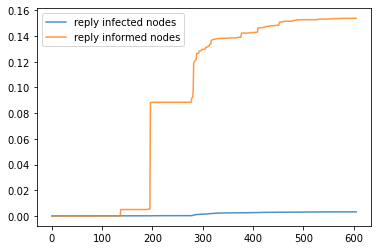

In [18]:
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df, G_social_df, max_degree_reply, start_timestamp, end_timestamp, len(G_social.nodes()), name="reply", plot=True)

In [24]:
def simulate_spreading_n_nodes(graph_df, social_network_df, seed_nodes, start_timestamp, end_timestamp, number_of_nodes, name="name_not_given", plot=True):
    
    infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n = [], [], [], []
    
    for node in seed_nodes:
        infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(\
                graph_df, social_network_df, node, start_timestamp, end_timestamp, number_of_nodes, name=name, plot=plot)
        
        infected_nodes_n.append(infected_nodes)
        informed_nodes_n.append(informed_nodes)
        infected_nodes_time_n.append(infected_nodes_time)
        informed_nodes_time_n.append(informed_nodes_time)
        
    return infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n

In [59]:
def cum_to_diff(time):
    return np.array(time[1:]) - np.array(time[:-1])

In [60]:
def get_crosscorr(proc_n_1, proc_n_2):
    return np.mean([np.correlate(cum_to_diff(proc_1), cum_to_diff(proc_2), 'full') for proc_1, proc_2 in zip(proc_n_1, proc_n_2)])

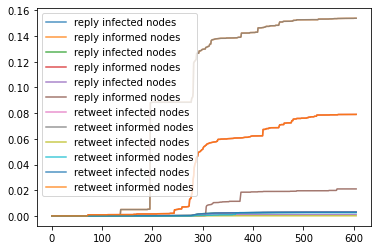

In [46]:
_, _, infected_nodes_time_rep, informed_nodes_time_rep = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_degree_reply, start_timestamp, end_timestamp, len(G_social.nodes()), name="reply", plot=True)
_, _, infected_nodes_time_ret, informed_nodes_time_ret = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_degree_retweet, start_timestamp, end_timestamp, len(G_social.nodes()), name="retweet", plot=True)

In [61]:
corr = get_crosscorr(informed_nodes_time_rep, informed_nodes_time_ret)

In [63]:
corr

7.0458480214340264e-06